# fashion mnist auto encoder

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

import tensorflow as tf

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
device = 'mps'

# data

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

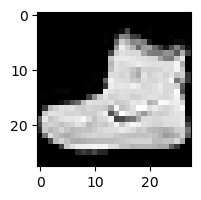

In [5]:
plt.figure(figsize=(2, 2))
plt.imshow(train_images[0], cmap='gray')

In [6]:
train_images[0].shape

(28, 28)

# custiom dataset

In [7]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms):
        super().__init__()
        self.data = [(transforms(image), label) for image, label in zip(images, labels)]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
transforms = T.Compose([T.ToTensor()])

train_dataset = customdataset(train_images, train_labels, transforms)
test_dataset = customdataset(test_images, test_labels, transforms)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


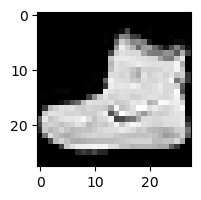

In [9]:
plt.figure(figsize=(2, 2))
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')

In [10]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

In [11]:
len(train_dataset)

48000

In [12]:
batch_size = 2000

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

# model

In [13]:
class auto_encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
                                           torch.nn.BatchNorm2d(num_features=16),
                                           torch.nn.ReLU(),
                                           torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
                                           torch.nn.BatchNorm2d(num_features=32),
                                           torch.nn.ReLU(),
                                           torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=0),
                                           torch.nn.BatchNorm2d(num_features=64),
                                           torch.nn.ReLU(),
                                           torch.nn.Flatten(),
                                           torch.nn.Linear(in_features=64*14*14, out_features=2048),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(in_features=2048, out_features=256),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(in_features=256, out_features=128),
                                           torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential(torch.nn.Linear(in_features=128, out_features=256),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(in_features=256, out_features=512),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(in_features=512, out_features=784))

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = decoded.view(-1, 1, 28, 28)
        
        return encoded, decoded, output

In [14]:
model_tmp = auto_encoder()
summary(model_tmp, input_size=(1, 28, 28))

del model_tmp
gc.collect()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 64, 14, 14]           8,256
       BatchNorm2d-8           [-1, 64, 14, 14]             128
              ReLU-9           [-1, 64, 14, 14]               0
          Flatten-10                [-1, 12544]               0
           Linear-11                 [-1, 2048]      25,692,160
             ReLU-12                 [-1, 2048]               0
           Linear-13                  [-1, 256]         524,544
             ReLU-14                  [

12

In [15]:
model_tmp = auto_encoder()
layer_li = list(model_tmp.children())
print(len(layer_li))

del model_tmp
gc.collect()

2


0

# train, evaluation

In [16]:
def training(model, train_dataloader, train_dataset, optimizer, criterion, epoch, num_epochs):
    model.train()
    train_loss = 0.0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)

        encoded, decoded, output = model(images)
        loss = criterion(decoded, images.view(-1, 28*28))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)

    return model, train_loss

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)

            encoded, decoded, output = model(images)
            loss = criterion(decoded, images.view(-1, 28*28))

            valid_loss += loss.item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)

    return model, valid_loss

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, optimizer, criterion, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model, train_loss = training(model, train_dataloader, train_dataset, optimizer, criterion, epoch, num_epochs)
        model, valid_loss = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(train_loss, valid_loss)

    return model

In [17]:
model = auto_encoder()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 64, 14, 14]           8,256
       BatchNorm2d-8           [-1, 64, 14, 14]             128
              ReLU-9           [-1, 64, 14, 14]               0
          Flatten-10                [-1, 12544]               0
           Linear-11                 [-1, 2048]      25,692,160
             ReLU-12                 [-1, 2048]               0
           Linear-13                  [-1, 256]         524,544
             ReLU-14                  [

In [18]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, optimizer, criterion, 10)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.08928808538864057 0.09488603100180626


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.04878471667567889 0.04304190042118231


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.03738153461987773 0.03350938794513544


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.030206205633779366 0.02795516575376193


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.026246239586422842 0.02534414983044068


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.024205125014608104 0.023828767860929172


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.022974986893435318 0.022314959516127903


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.02156565027932326 0.020953539138038952


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.02062511684683462 0.02013637622197469


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0.019812278759976227 0.019522168673574924


# test

In [19]:
model.eval()
model.to(device)

total_decoded = []
total_outputs = []
total_images = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)

        encoded, decoded, output = model(images)
        total_images.extend(images)
        total_decoded.extend(decoded)
        total_outputs.extend(output)

  0%|          | 0/5 [00:00<?, ?it/s]

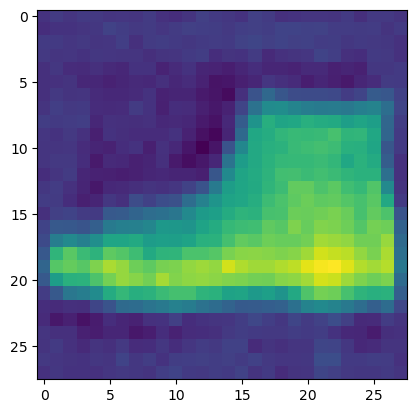

In [20]:
plt.imshow(np.array(total_outputs[0].squeeze().cpu()))

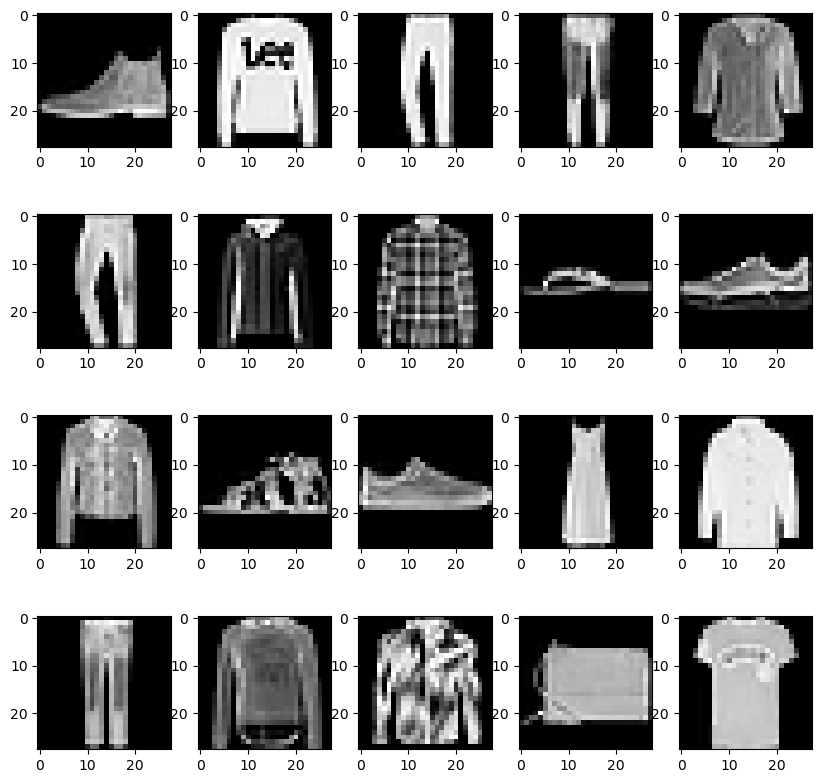

In [21]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_images[i].squeeze().cpu()), cmap='gray')

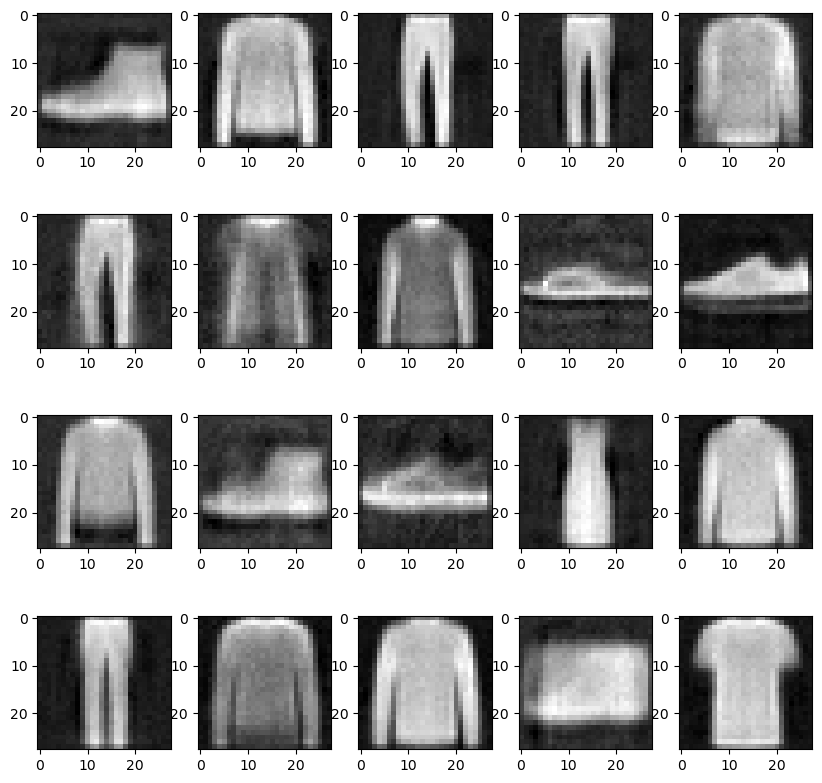

In [22]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_outputs[i].squeeze().cpu()), cmap='gray')